In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


 # EDA on full brain Drosophila larva connectome

 ## Definitions

 **G**: the raw-weight graph for the full graph.

 **Gaa**: the raw-weight graph for axo-axonic synapses.

 **Gad**: the raw-weight graph for axo-dendritic synapses.

 **Gda**: the raw-weight graph for dendro-dendritic synapses.

 **Gdd**: the raw-weight graph for dendro-axonic synapses.

In [1]:
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import GaussianCluster, KMeansCluster
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, OmnibusEmbed
from graspy.models import DCSBMEstimator
from graspy.plot import degreeplot, edgeplot, gridplot, heatmap, pairplot
from graspy.utils import augment_diagonal, binarize, cartprod, pass_to_ranks, to_laplace
from joblib.parallel import Parallel, delayed
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from spherecluster import SphericalKMeans

from src.data import load_everything, load_networkx
from src.models import GridSearchUS
from src.utils import get_best, meta_to_array, relabel, savefig, unique_by_size
from src.visualization import incidence_plot, screeplot

# Global general parameters
MB_VERSION = "mb_2019-09-23"
BRAIN_VERSION = "2019-09-18-v2"
GRAPH_TYPES = ["Gad", "Gaa", "Gdd", "Gda"]
GRAPH_TYPE_LABELS = [r"A $\to$ D", r"A $\to$ A", r"D $\to$ D", r"D $\to$ A"]
N_GRAPH_TYPES = len(GRAPH_TYPES)

# Set up plotting constants
palette = "deep"
plt.style.use("seaborn-white")
sns.set_palette(palette)
sns.set_context("talk", font_scale=1)

# Load data
adj, class_labels, side_labels = load_everything(
    "G", version=BRAIN_VERSION, return_class=True, return_side=True
)


degrees = adj.sum(axis=0) + adj.sum(axis=1)
sort_inds = np.argsort(degrees)[::-1]
class_labels = class_labels[sort_inds]
adj = adj[np.ix_(sort_inds, sort_inds)]

name_map = {
    "CN": "Unknown",
    "DANs": "DAN",
    "KCs": "KC",
    "LHN": "Unknown",
    "LHN; CN": "Unknown",
    "MBINs": "MBIN",
    "MBON": "MBON",
    "MBON; CN": "MBON",
    "OANs": "OAN",
    "ORN mPNs": "mPN",
    "ORN uPNs": "uPN",
    "tPNs": "tPN",
    "vPNs": "vPN",
    "Unidentified": "Unknown",
    "Other": "Unknown",
}
class_labels = np.array(itemgetter(*class_labels)(name_map))


# Now load all 4 colors
color_adjs = []
for t in GRAPH_TYPES:
    adj = load_everything(t)
    adj = adj[np.ix_(sort_inds, sort_inds)]
    color_adjs.append(adj)

sum_adj = np.array(color_adjs).sum(axis=0)


/miniconda3/envs/maggot_models/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


 ## Print some summary statistics and plot the adjacency matrices

Full Brain

Number of vertices: 2288

G
Number of edges: 89936
Sparsity: 0.01717993544916622
Number of synapses: 273947
Median node in degree: 31.0
Median node out degree: 34.0

Gad
Number of edges: 48879
Sparsity: 0.009337062631424519
Number of synapses: 172271
Median node in degree: 16.0
Median node out degree: 19.0

Gaa
Number of edges: 32132
Sparsity: 0.006137983519976527
Number of synapses: 71525
Median node in degree: 9.0
Median node out degree: 10.0

Gdd
Number of edges: 9635
Sparsity: 0.0018405163455425693
Number of synapses: 23991
Median node in degree: 3.0
Median node out degree: 0.0

Gda
Number of edges: 3637
Sparsity: 0.0006947543278399921
Number of synapses: 6160
Median node in degree: 1.0
Median node out degree: 0.0



<Figure size 360x360 with 0 Axes>

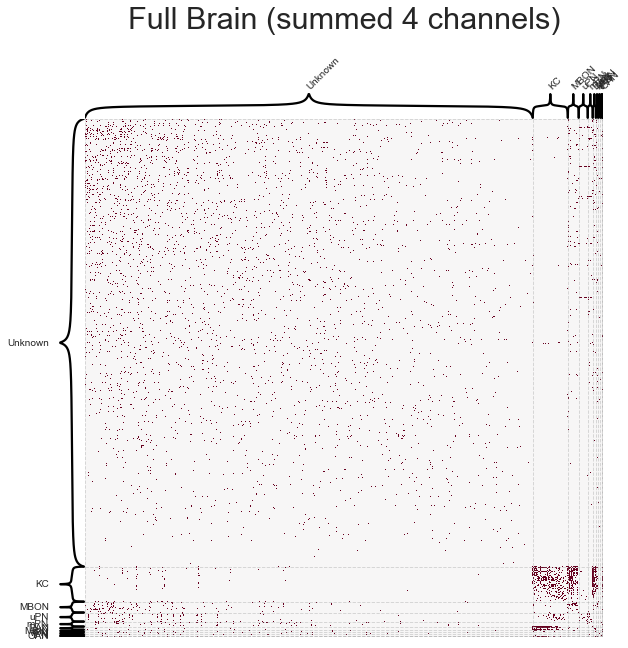

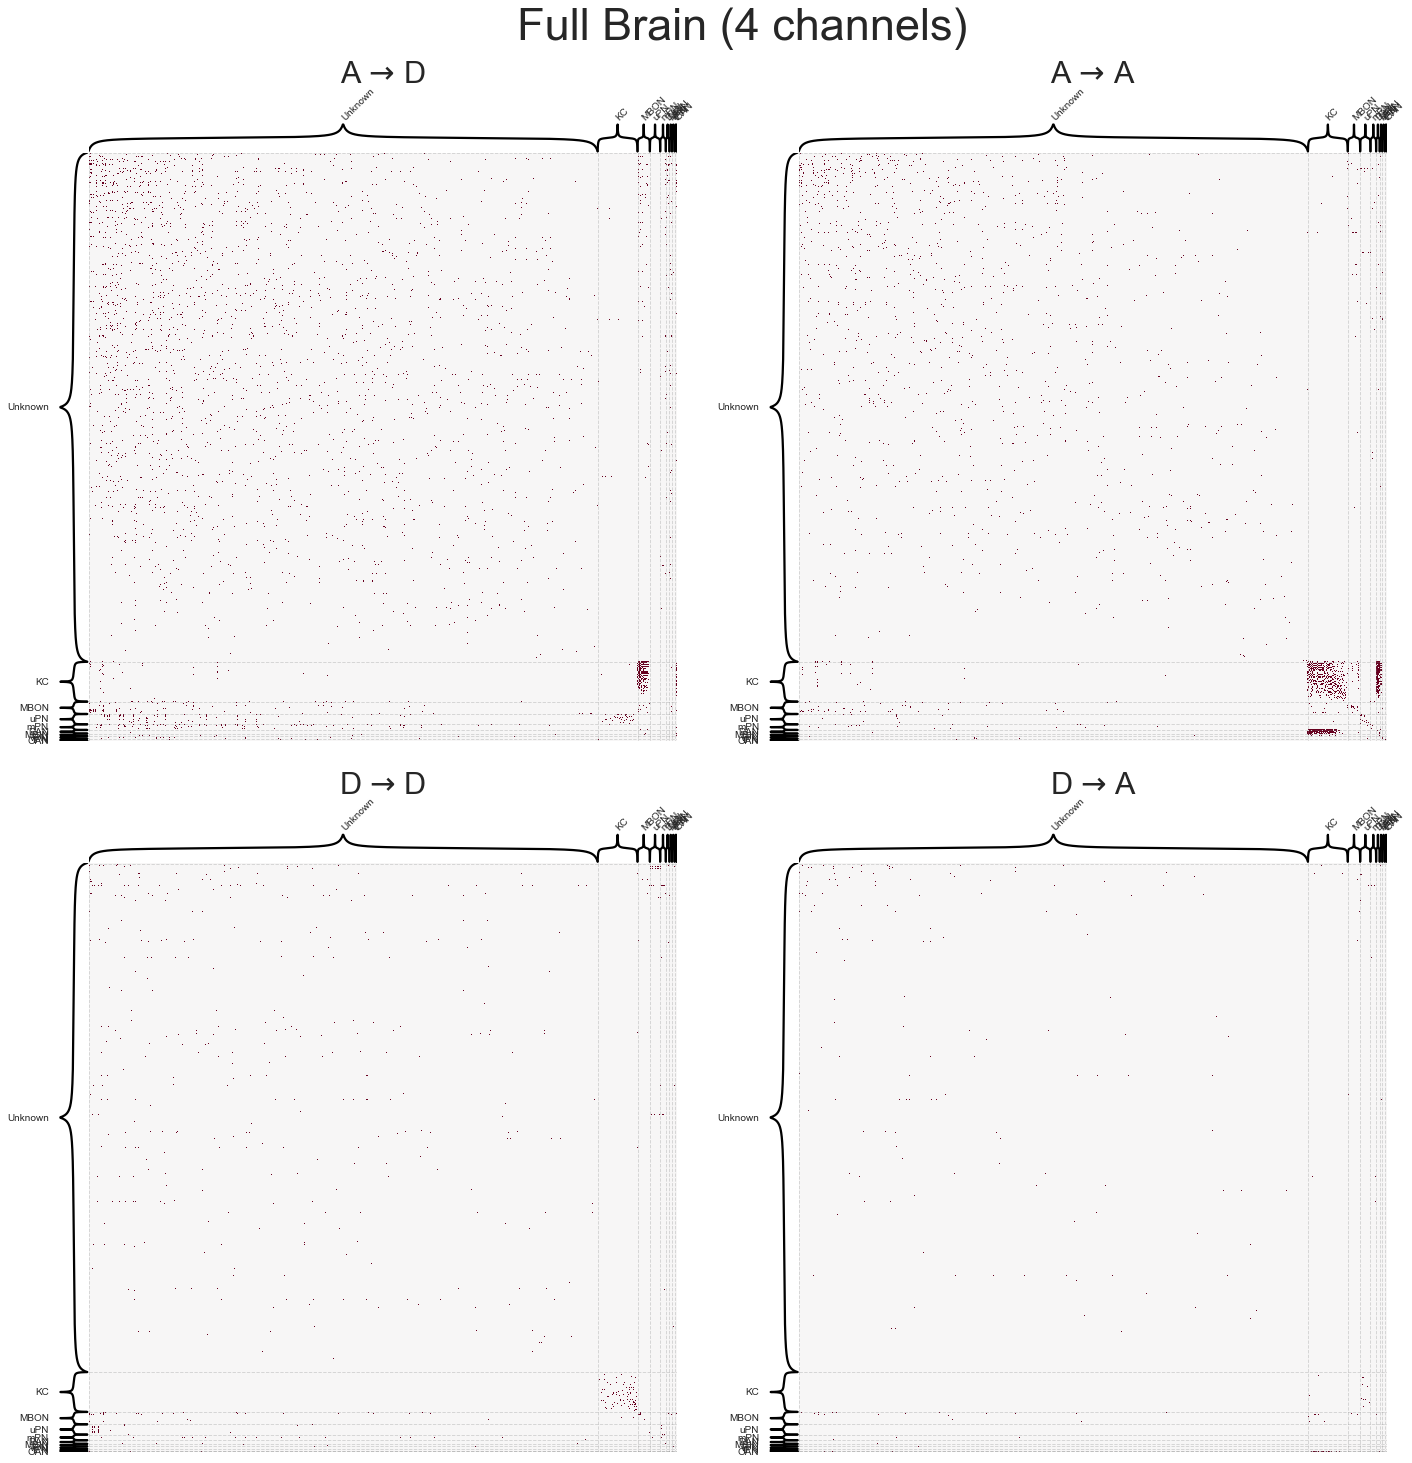

In [2]:
# Print some stats
n_verts = adj.shape[0]
print("Full Brain")
print()
print(f"Number of vertices: {n_verts}")
print()

name = "G"
g = sum_adj
print(name)
print(f"Number of edges: {np.count_nonzero(g)}")
print(f"Sparsity: {np.count_nonzero(g) / (n_verts**2)}")
print(f"Number of synapses: {int(g.sum())}")
median_in_degree = np.median(np.count_nonzero(g, axis=0))
median_out_degree = np.median(np.count_nonzero(g, axis=1))
print(f"Median node in degree: {median_in_degree}")
print(f"Median node out degree: {median_out_degree}")
print()

for g, name in zip(color_adjs, GRAPH_TYPES):
    print(name)
    print(f"Number of edges: {np.count_nonzero(g)}")
    print(f"Sparsity: {np.count_nonzero(g) / (n_verts**2)}")
    print(f"Number of synapses: {int(g.sum())}")
    median_in_degree = np.median(np.count_nonzero(g, axis=0))
    median_out_degree = np.median(np.count_nonzero(g, axis=1))
    print(f"Median node in degree: {median_in_degree}")
    print(f"Median node out degree: {median_out_degree}")
    print()


# Plot the adjacency matrix for the summed graph
sns.set_context("talk", font_scale=1)

plt.figure(figsize=(5, 5))
ax = heatmap(
    binarize(sum_adj),
    inner_hier_labels=class_labels,
    hier_label_fontsize=10,
    sort_nodes=False,
    cbar=False,
    title="Full Brain (summed 4 channels)",
    title_pad=90,
    font_scale=1.7,
)

# Plot the adjacency matrix for the 4-color graphs
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.ravel()
for i, g in enumerate(color_adjs):
    heatmap(
        binarize(g),
        inner_hier_labels=class_labels,
        hier_label_fontsize=10,
        sort_nodes=False,
        ax=ax[i],
        cbar=False,
        title=GRAPH_TYPE_LABELS[i],
        title_pad=70,
        font_scale=1.7,
    )
plt.suptitle("Full Brain (4 channels)", fontsize=45, x=0.525, y=1.02)
plt.tight_layout()


 ## Plot edge weight sums (edgesums) and degrees for the full (G) graph
 Note that weights here are the actual number of synapses

Text(0.5, 0, '# outbound edges')

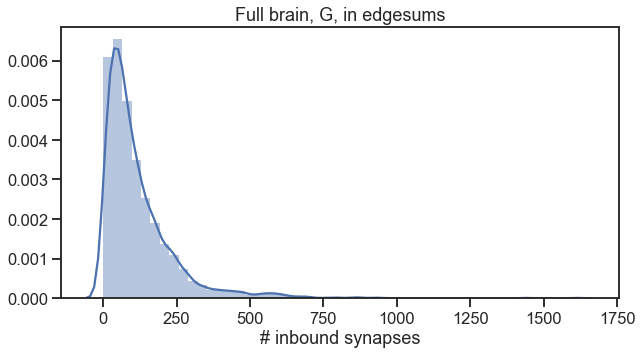

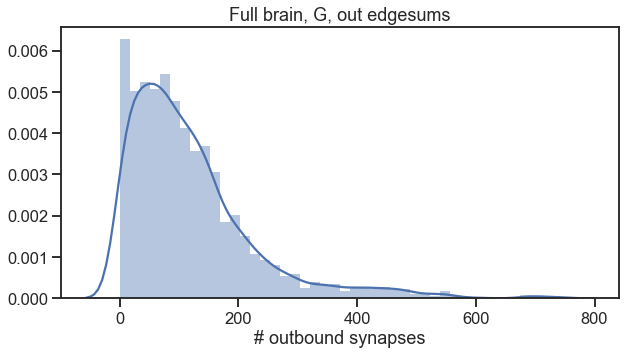

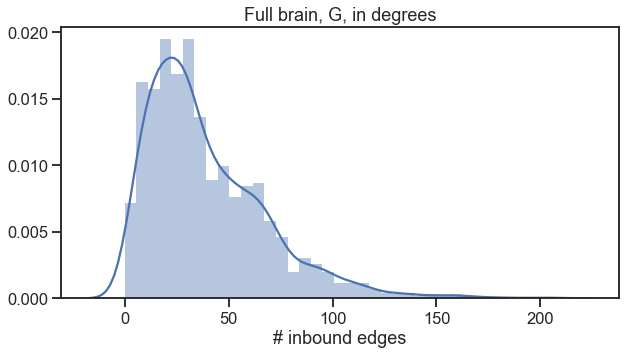

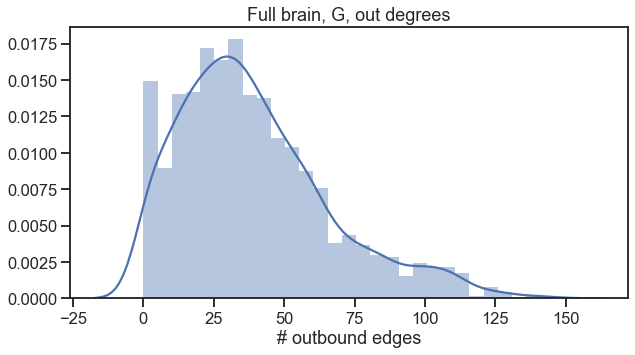

In [3]:

in_edgesum = sum_adj.sum(axis=0)
out_edgesum = sum_adj.sum(axis=1)
in_degree = np.count_nonzero(sum_adj, axis=0)
out_degree = np.count_nonzero(sum_adj, axis=1)

figsize = (10, 5)
sns.plotting_context("talk", font_scale=1.25)

plt.figure(figsize=figsize)
sns.distplot(in_edgesum)
plt.title("Full brain, G, in edgesums")
plt.xlabel("# inbound synapses")

plt.figure(figsize=figsize)
sns.distplot(out_edgesum)
plt.title("Full brain, G, out edgesums")
plt.xlabel("# outbound synapses")


plt.figure(figsize=figsize)
sns.distplot(in_degree)
plt.title("Full brain, G, in degrees")
plt.xlabel("# inbound edges")

plt.figure(figsize=figsize)
sns.distplot(out_degree)
plt.title("Full brain, G, out degrees")
plt.xlabel("# outbound edges")


 ## Look at edgesums in different ways, and make plots for the 4-color edgesums as well
 First two plots are still for **G**, the rest are for the 4-color

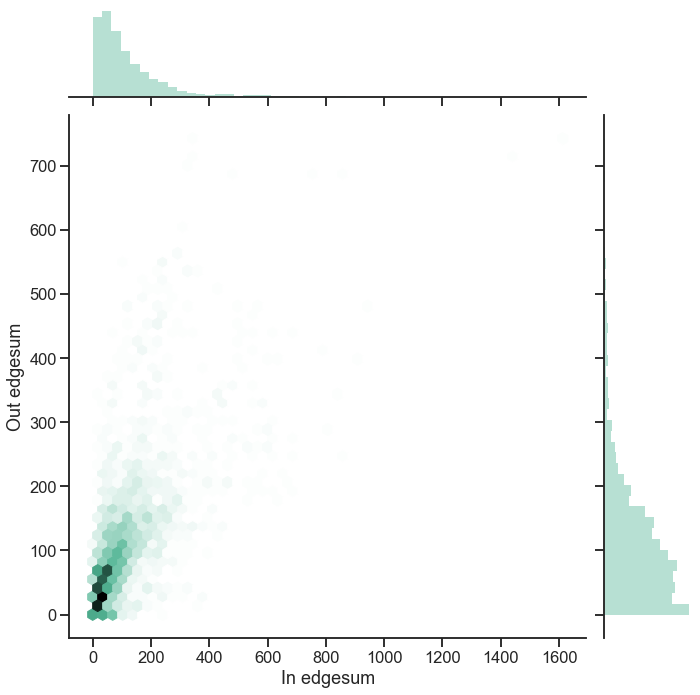

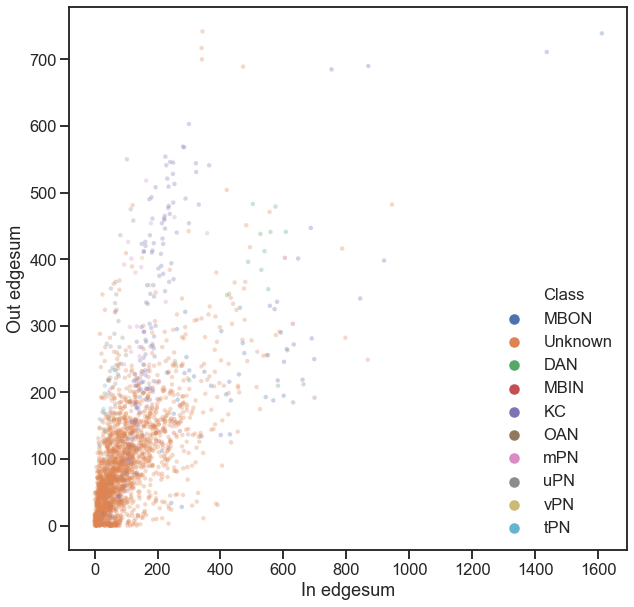

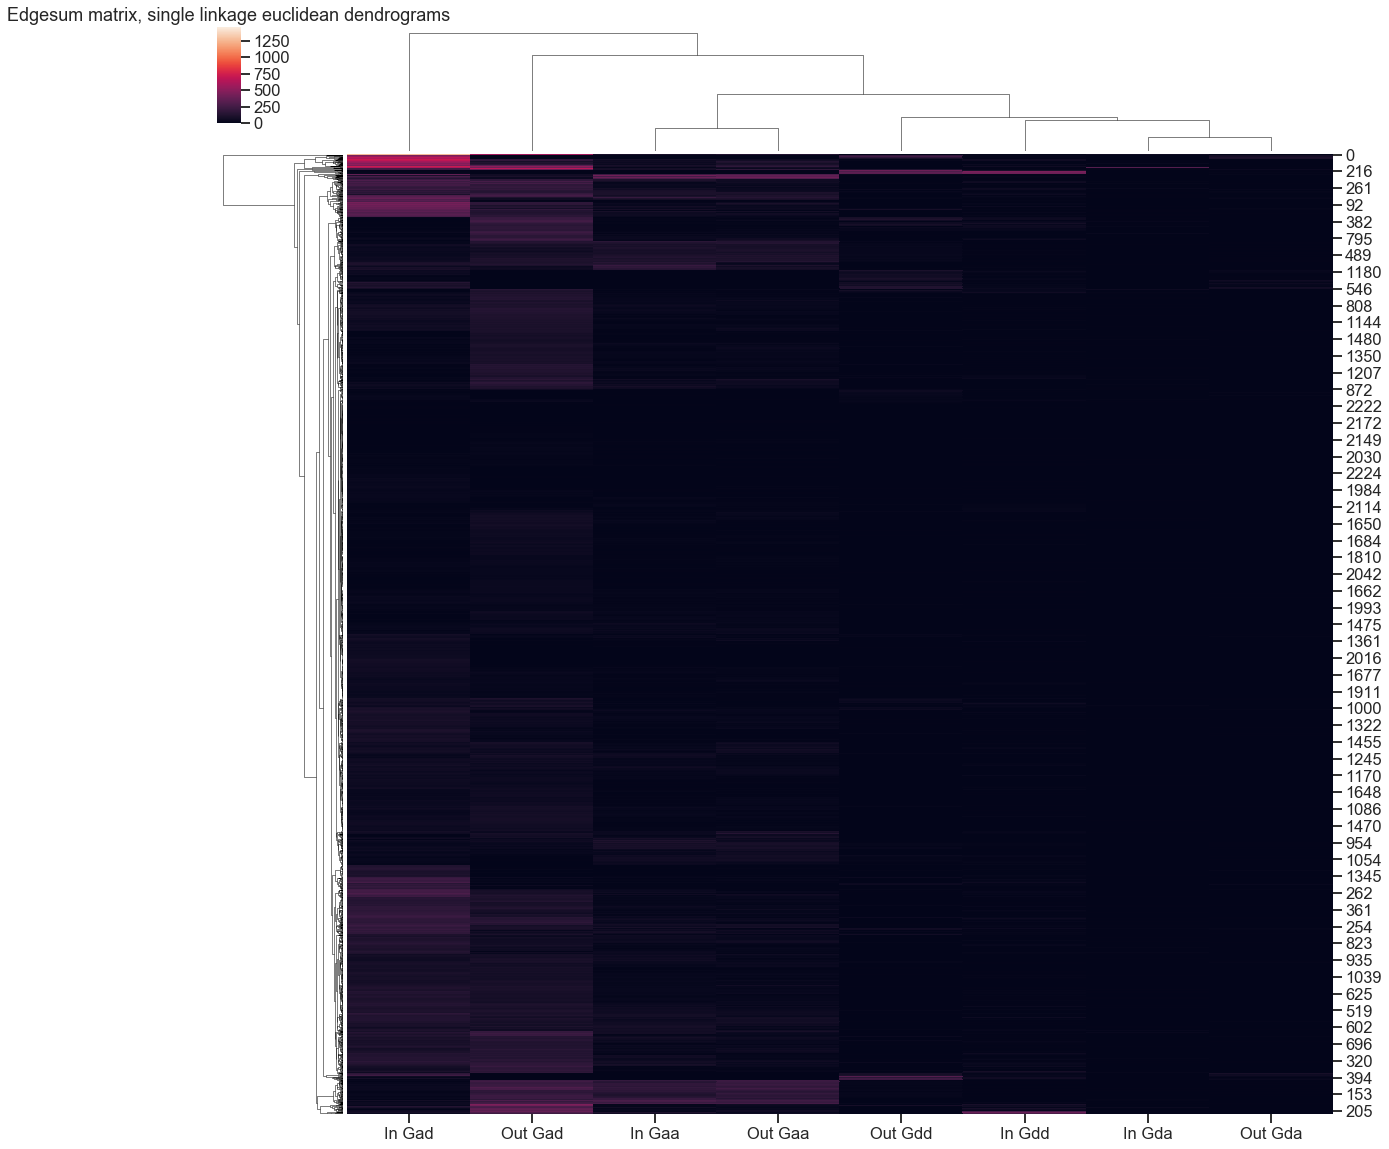

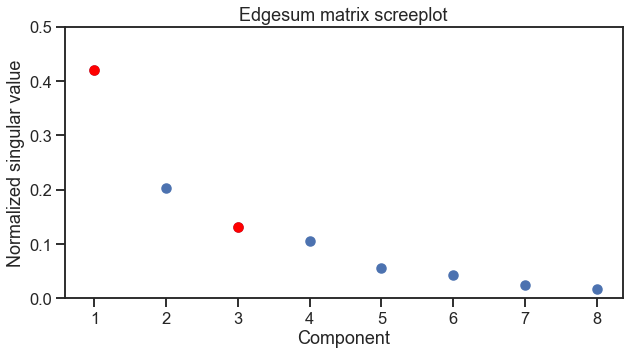

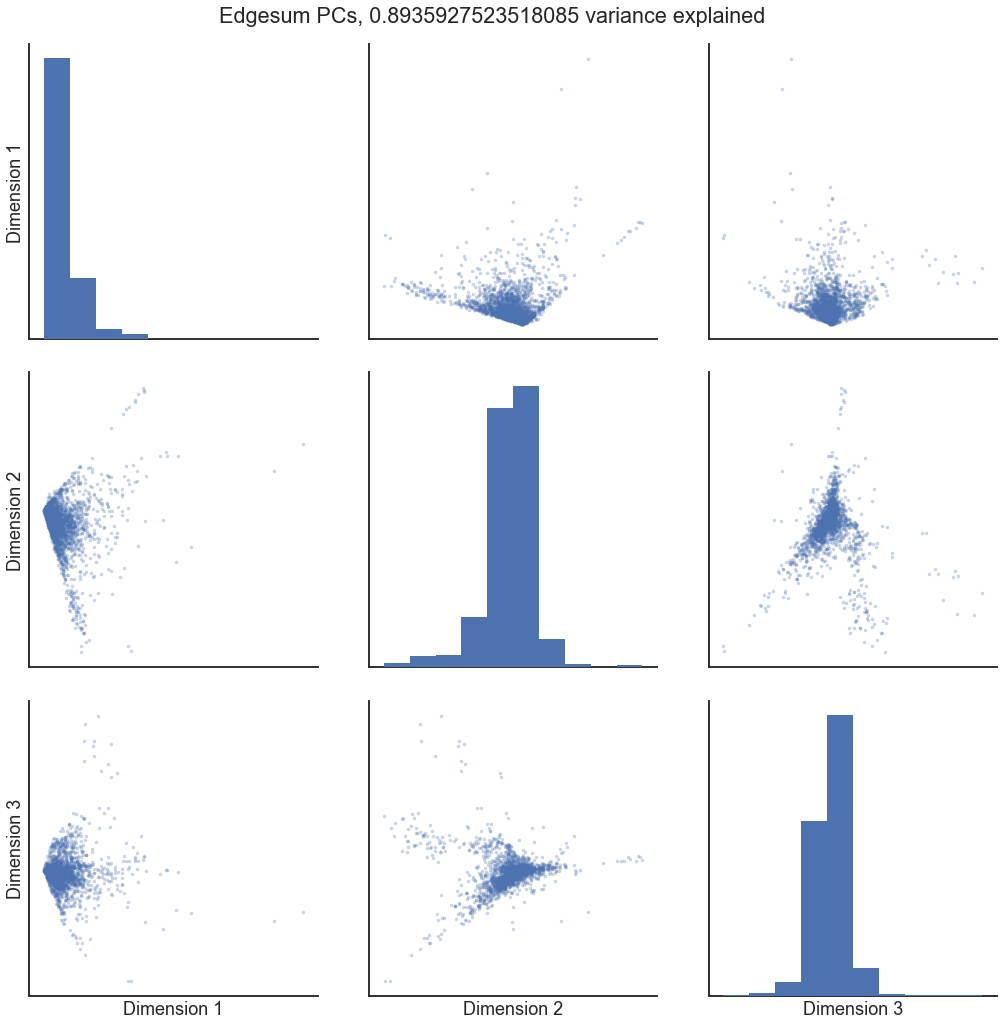

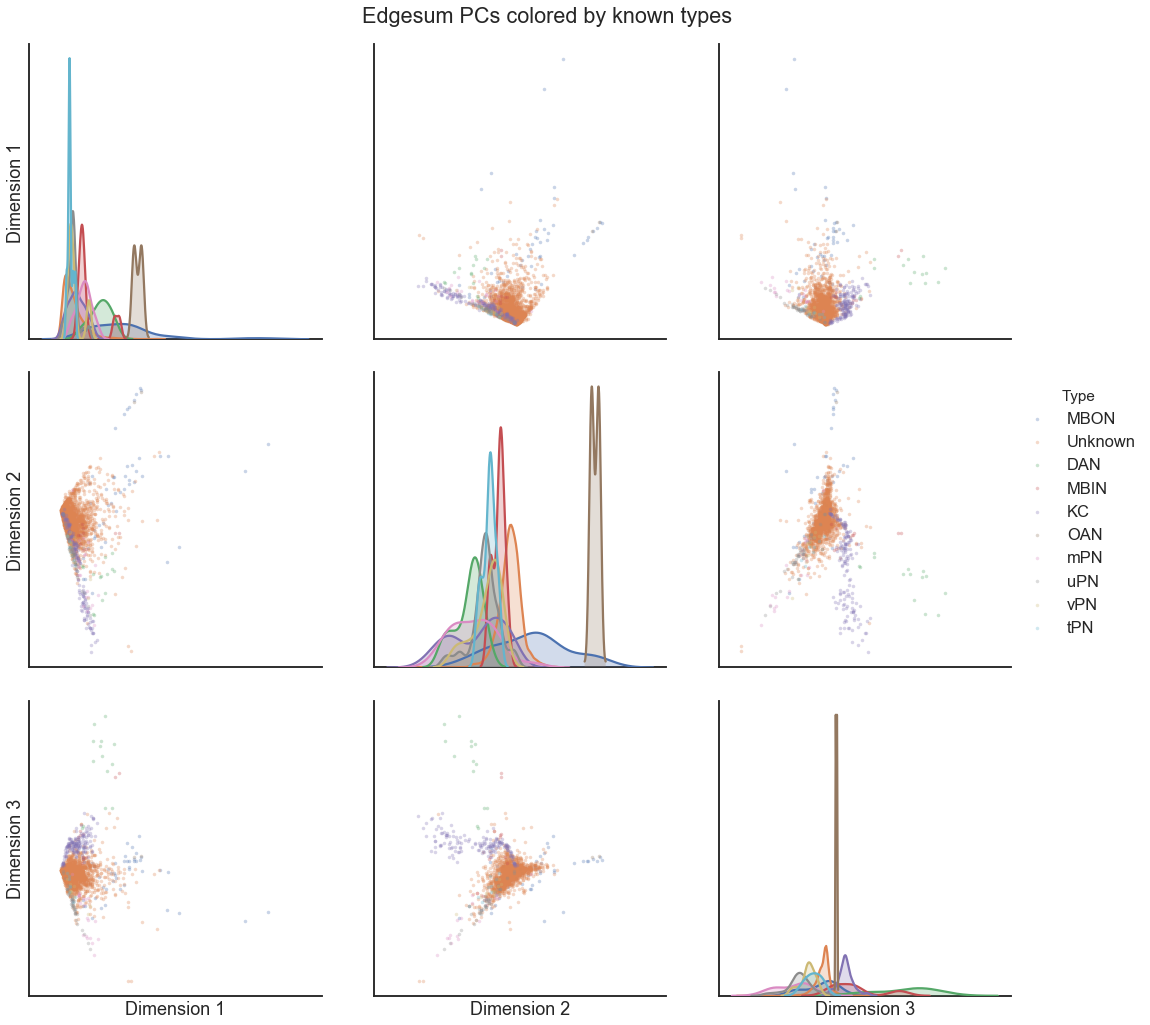

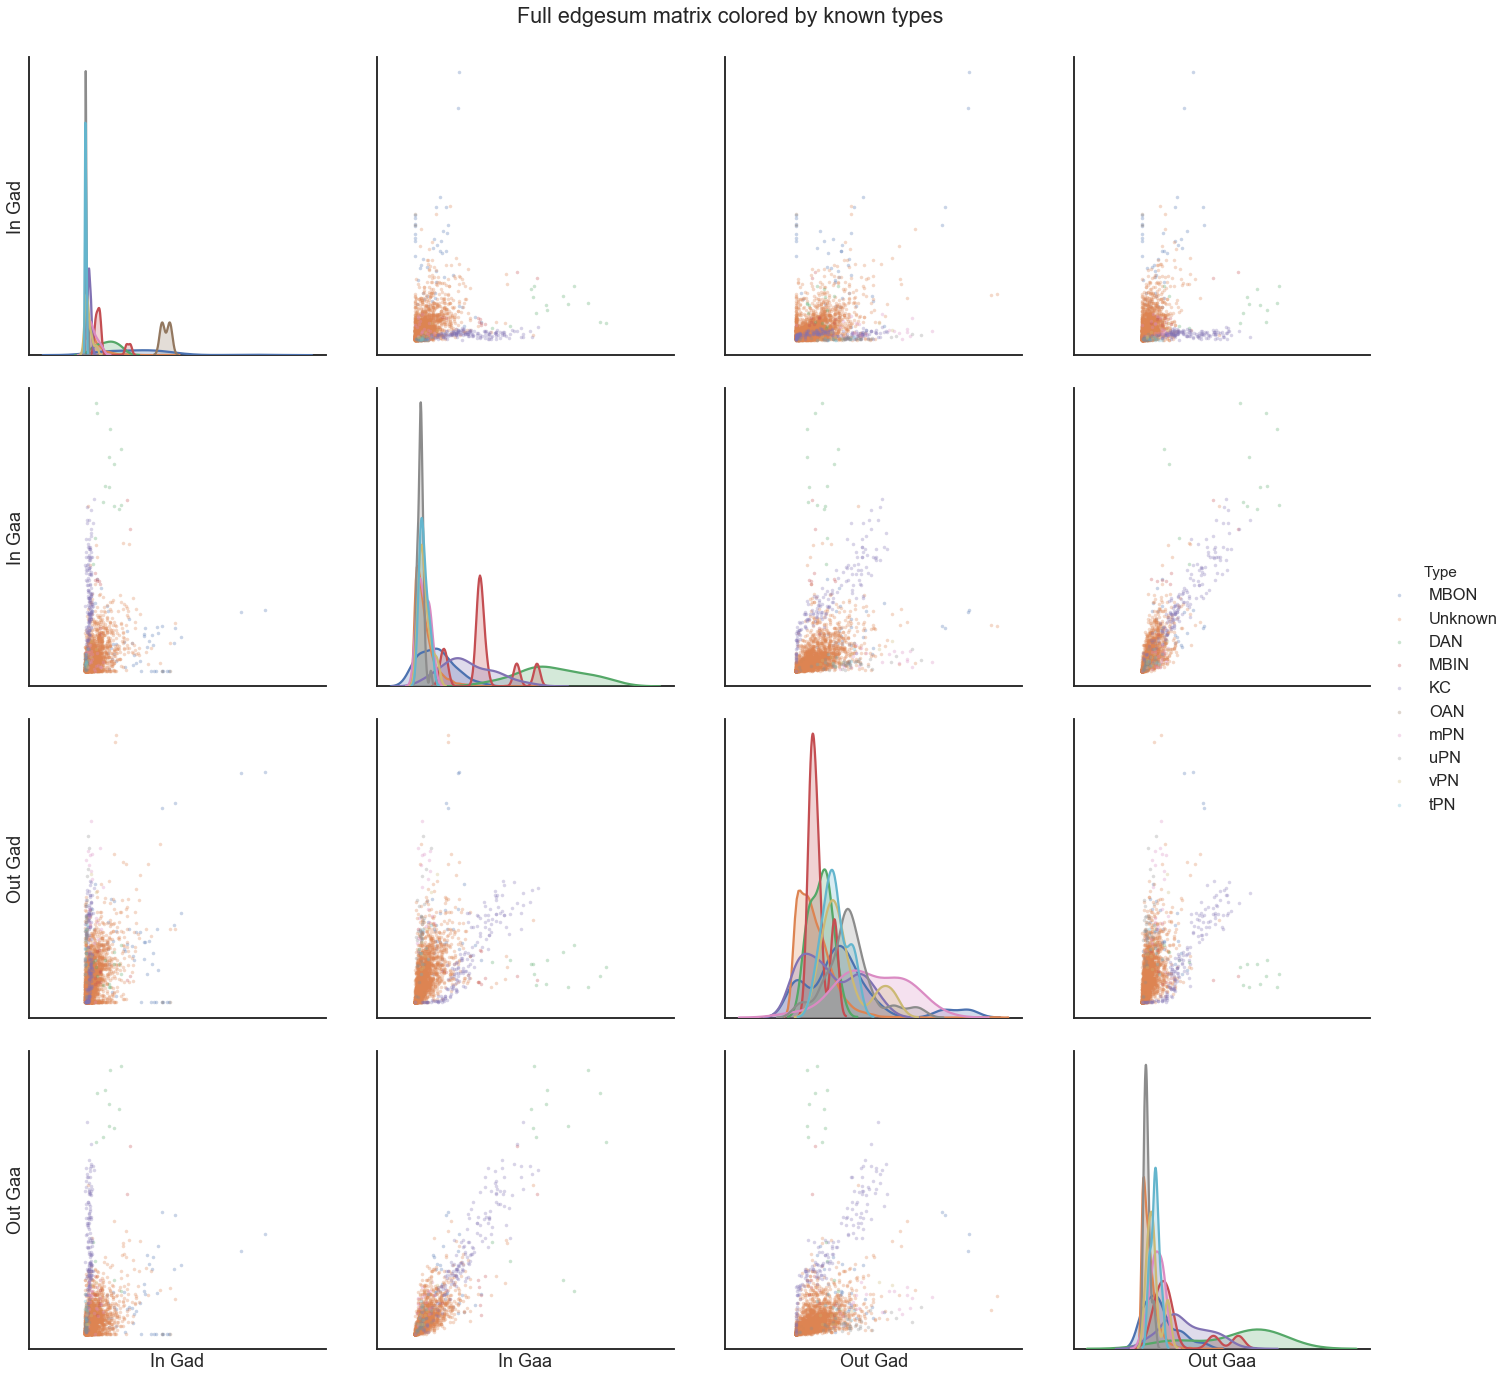

In [4]:


def calc_edgesums(adjs, *args):
    deg_mat = np.zeros((n_verts, 2 * N_GRAPH_TYPES))
    for i, g in enumerate(adjs):
        deg_mat[:, i] = g.sum(axis=0)
        deg_mat[:, i + N_GRAPH_TYPES] = g.sum(axis=1)
    return deg_mat


edgesum_flat_mat = np.stack((in_edgesum, out_edgesum), axis=1)
edgesum_flat_df = pd.DataFrame(
    data=edgesum_flat_mat, columns=("In edgesum", "Out edgesum")
)
edgesum_flat_df["Class"] = class_labels
sns.jointplot(
    data=edgesum_flat_df,
    x="In edgesum",
    y="Out edgesum",
    kind="hex",
    height=10,
    color="#4CB391",
)
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=edgesum_flat_df,
    x="In edgesum",
    y="Out edgesum",
    hue="Class",
    s=20,
    alpha=0.3,
    linewidth=0,
    palette=palette,
)


edgesum_mat = calc_edgesums(color_adjs)
in_cols = ["In " + n for n in GRAPH_TYPES]
out_cols = ["Out " + n for n in GRAPH_TYPES]
cols = np.array(in_cols + out_cols)

edgesum_df = pd.DataFrame(data=edgesum_mat, columns=cols)

figsize = (20, 20)
sns.clustermap(edgesum_df, figsize=figsize)
plt.title("Edgesum matrix, single linkage euclidean dendrograms", loc="center")


screeplot(edgesum_mat, cumulative=False, title="Edgesum matrix screeplot")
plt.ylim((0, 0.5))

pca = PCA(n_components=3)
edgesum_pcs = pca.fit_transform(edgesum_mat)

var_exp = np.sum(pca.explained_variance_ratio_)

pairplot(
    edgesum_pcs, height=5, alpha=0.3, title=f"Edgesum PCs, {var_exp} variance explained"
)
pairplot(
    edgesum_pcs,
    labels=class_labels,
    height=5,
    alpha=0.3,
    title="Edgesum PCs colored by known types",
    palette=palette,
)

pairplot(
    edgesum_mat[:, [0, 1, 4, 5]],
    labels=class_labels,
    height=5,
    alpha=0.3,
    title="Full edgesum matrix colored by known types",
    palette=palette,
    col_names=list(cols[[0, 1, 4, 5]]),
)


 # Block-wise nonzero edge weight distributions
 Shown for the full (summed) graph and split by the 4 colors

In [5]:


def unique_ind_map(labels):
    unique_labels, inverse_labels = np.unique(labels, return_inverse=True)
    label_ind_map = {}
    for i, class_name in enumerate(unique_labels):
        inds = np.where(inverse_labels == i)[0]
        label_ind_map[class_name] = inds
    return label_ind_map


def get_block_edgeweights(adj, labels):
    unique_labels = unique_by_size(labels)[0]
    ind_map = unique_ind_map(labels)
    dfs = []
    for i, from_label in enumerate(unique_labels):
        for j, to_label in enumerate(unique_labels):
            from_inds = ind_map[from_label]
            to_inds = ind_map[to_label]
            subgraph = adj[np.ix_(from_inds, to_inds)]
            edges = subgraph[subgraph != 0]
            from_indicator = len(edges) * [from_label]
            to_indicator = len(edges) * [to_label]
            temp_df = pd.DataFrame()
            temp_df["From"] = from_indicator
            temp_df["To"] = to_indicator
            temp_df["Weight"] = edges
            temp_df["Log weight"] = np.log(edges)
            dfs.append(temp_df)
    return pd.concat(dfs)


edge_df = get_block_edgeweights(sum_adj, class_labels)

 ## Nonzero edge weight for full graph

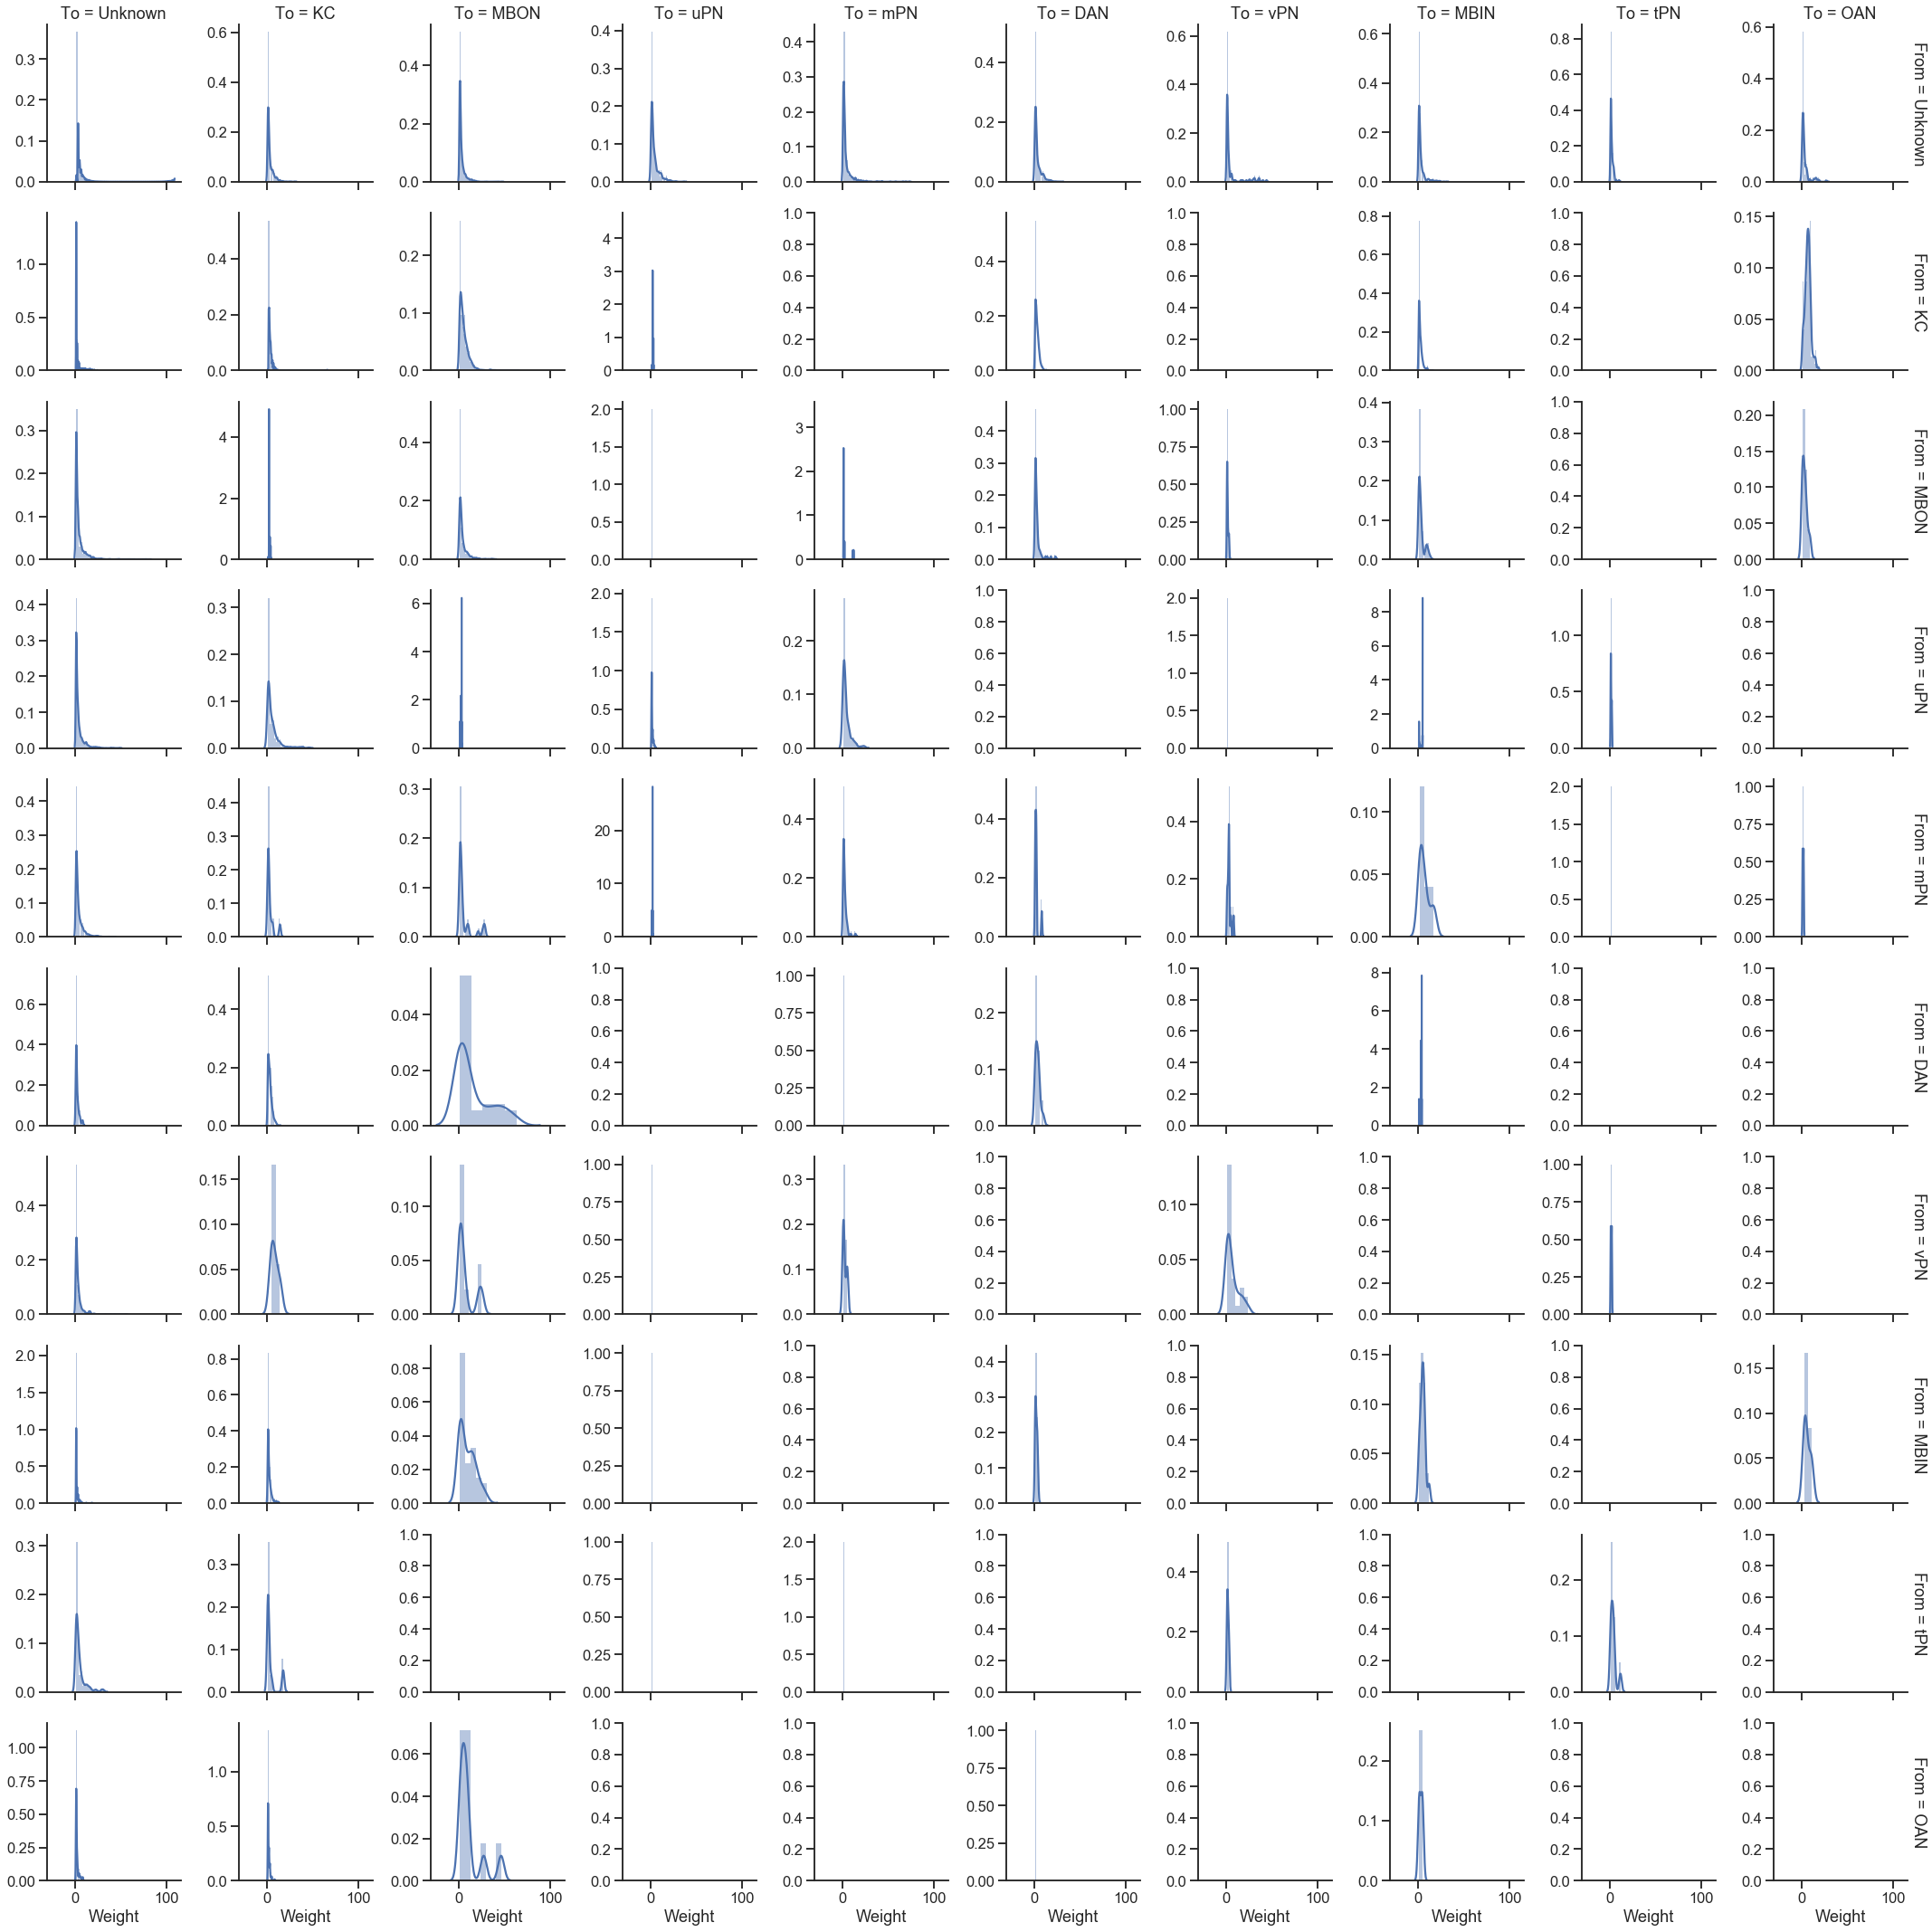

In [6]:
fg = sns.FacetGrid(
    edge_df, row="From", col="To", sharex=True, sharey=False, margin_titles=True
)
fg.map(sns.distplot, "Weight")


 ## Nonzero log edge weight for full graph

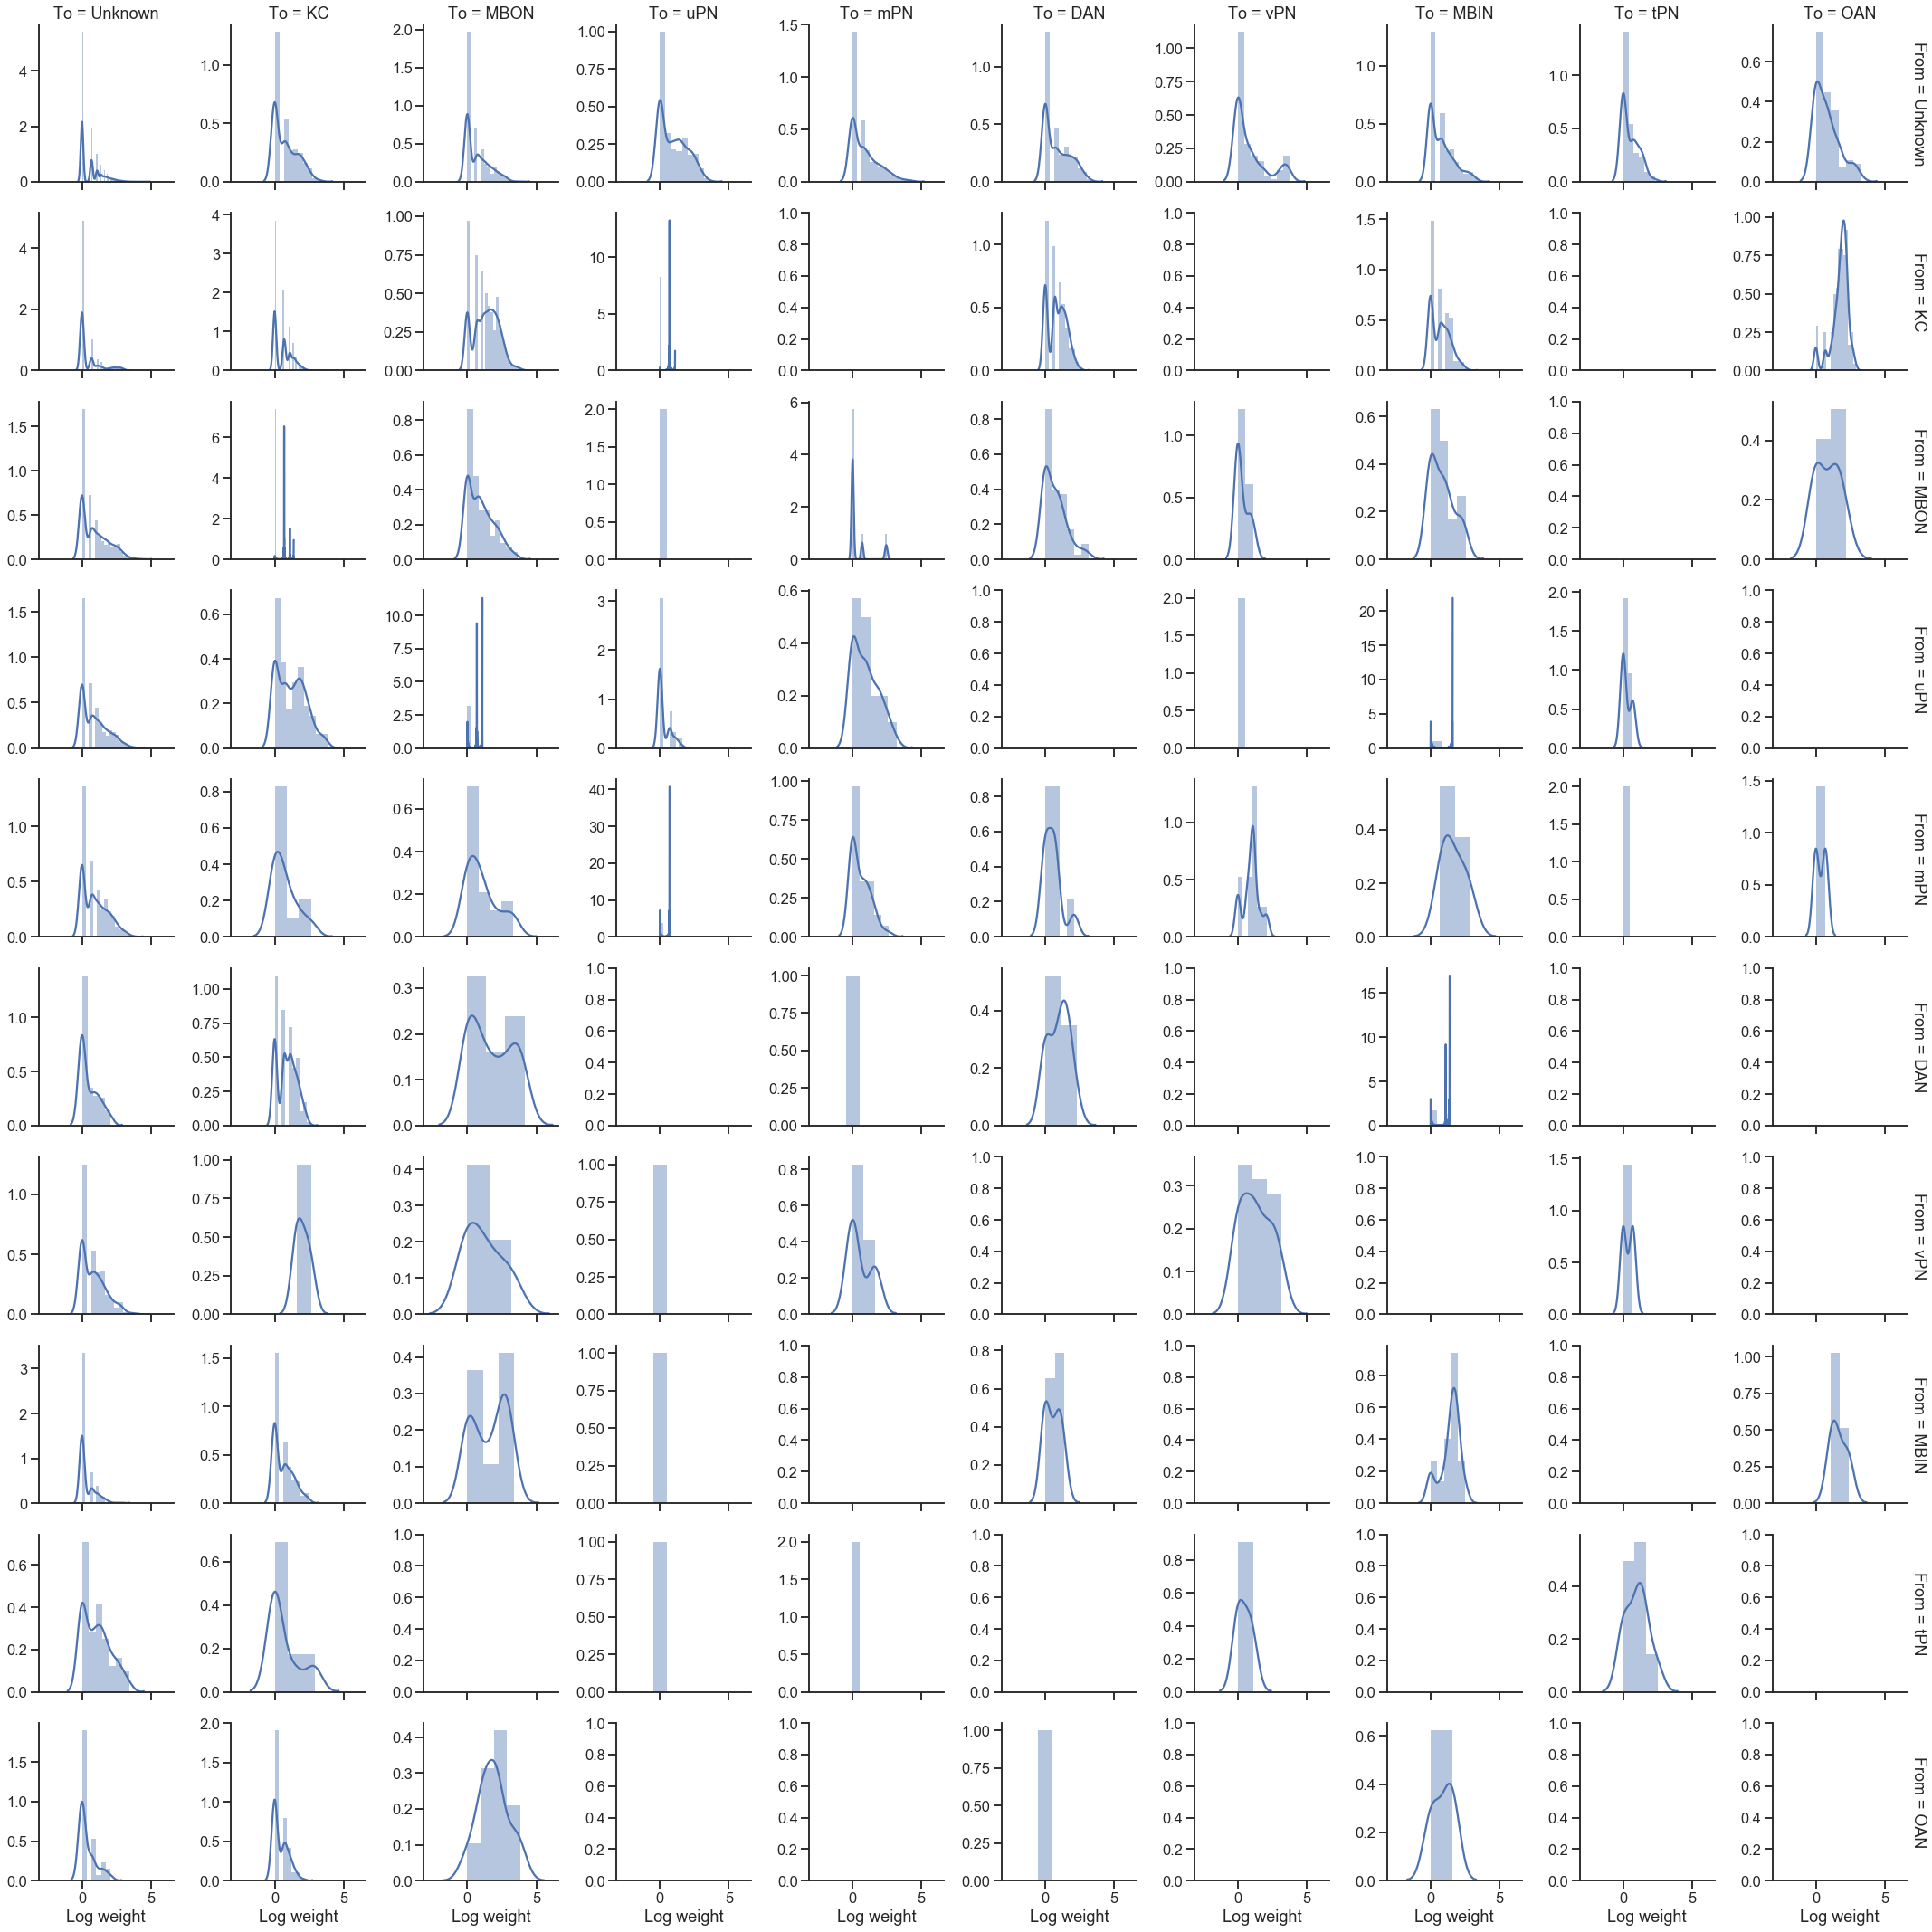

In [7]:
fg = sns.FacetGrid(
    edge_df, row="From", col="To", sharex=True, sharey=False, margin_titles=True
)
fg.map(sns.distplot, "Log weight")


In [8]:
dfs = []
for g, name in zip(color_adjs, GRAPH_TYPE_LABELS):
    edge_df = get_block_edgeweights(g, class_labels)
    edge_df["Edge type"] = name
    dfs.append(edge_df)
color_edge_df = pd.concat(dfs)


 # Nonzero edge weight split by synapse type

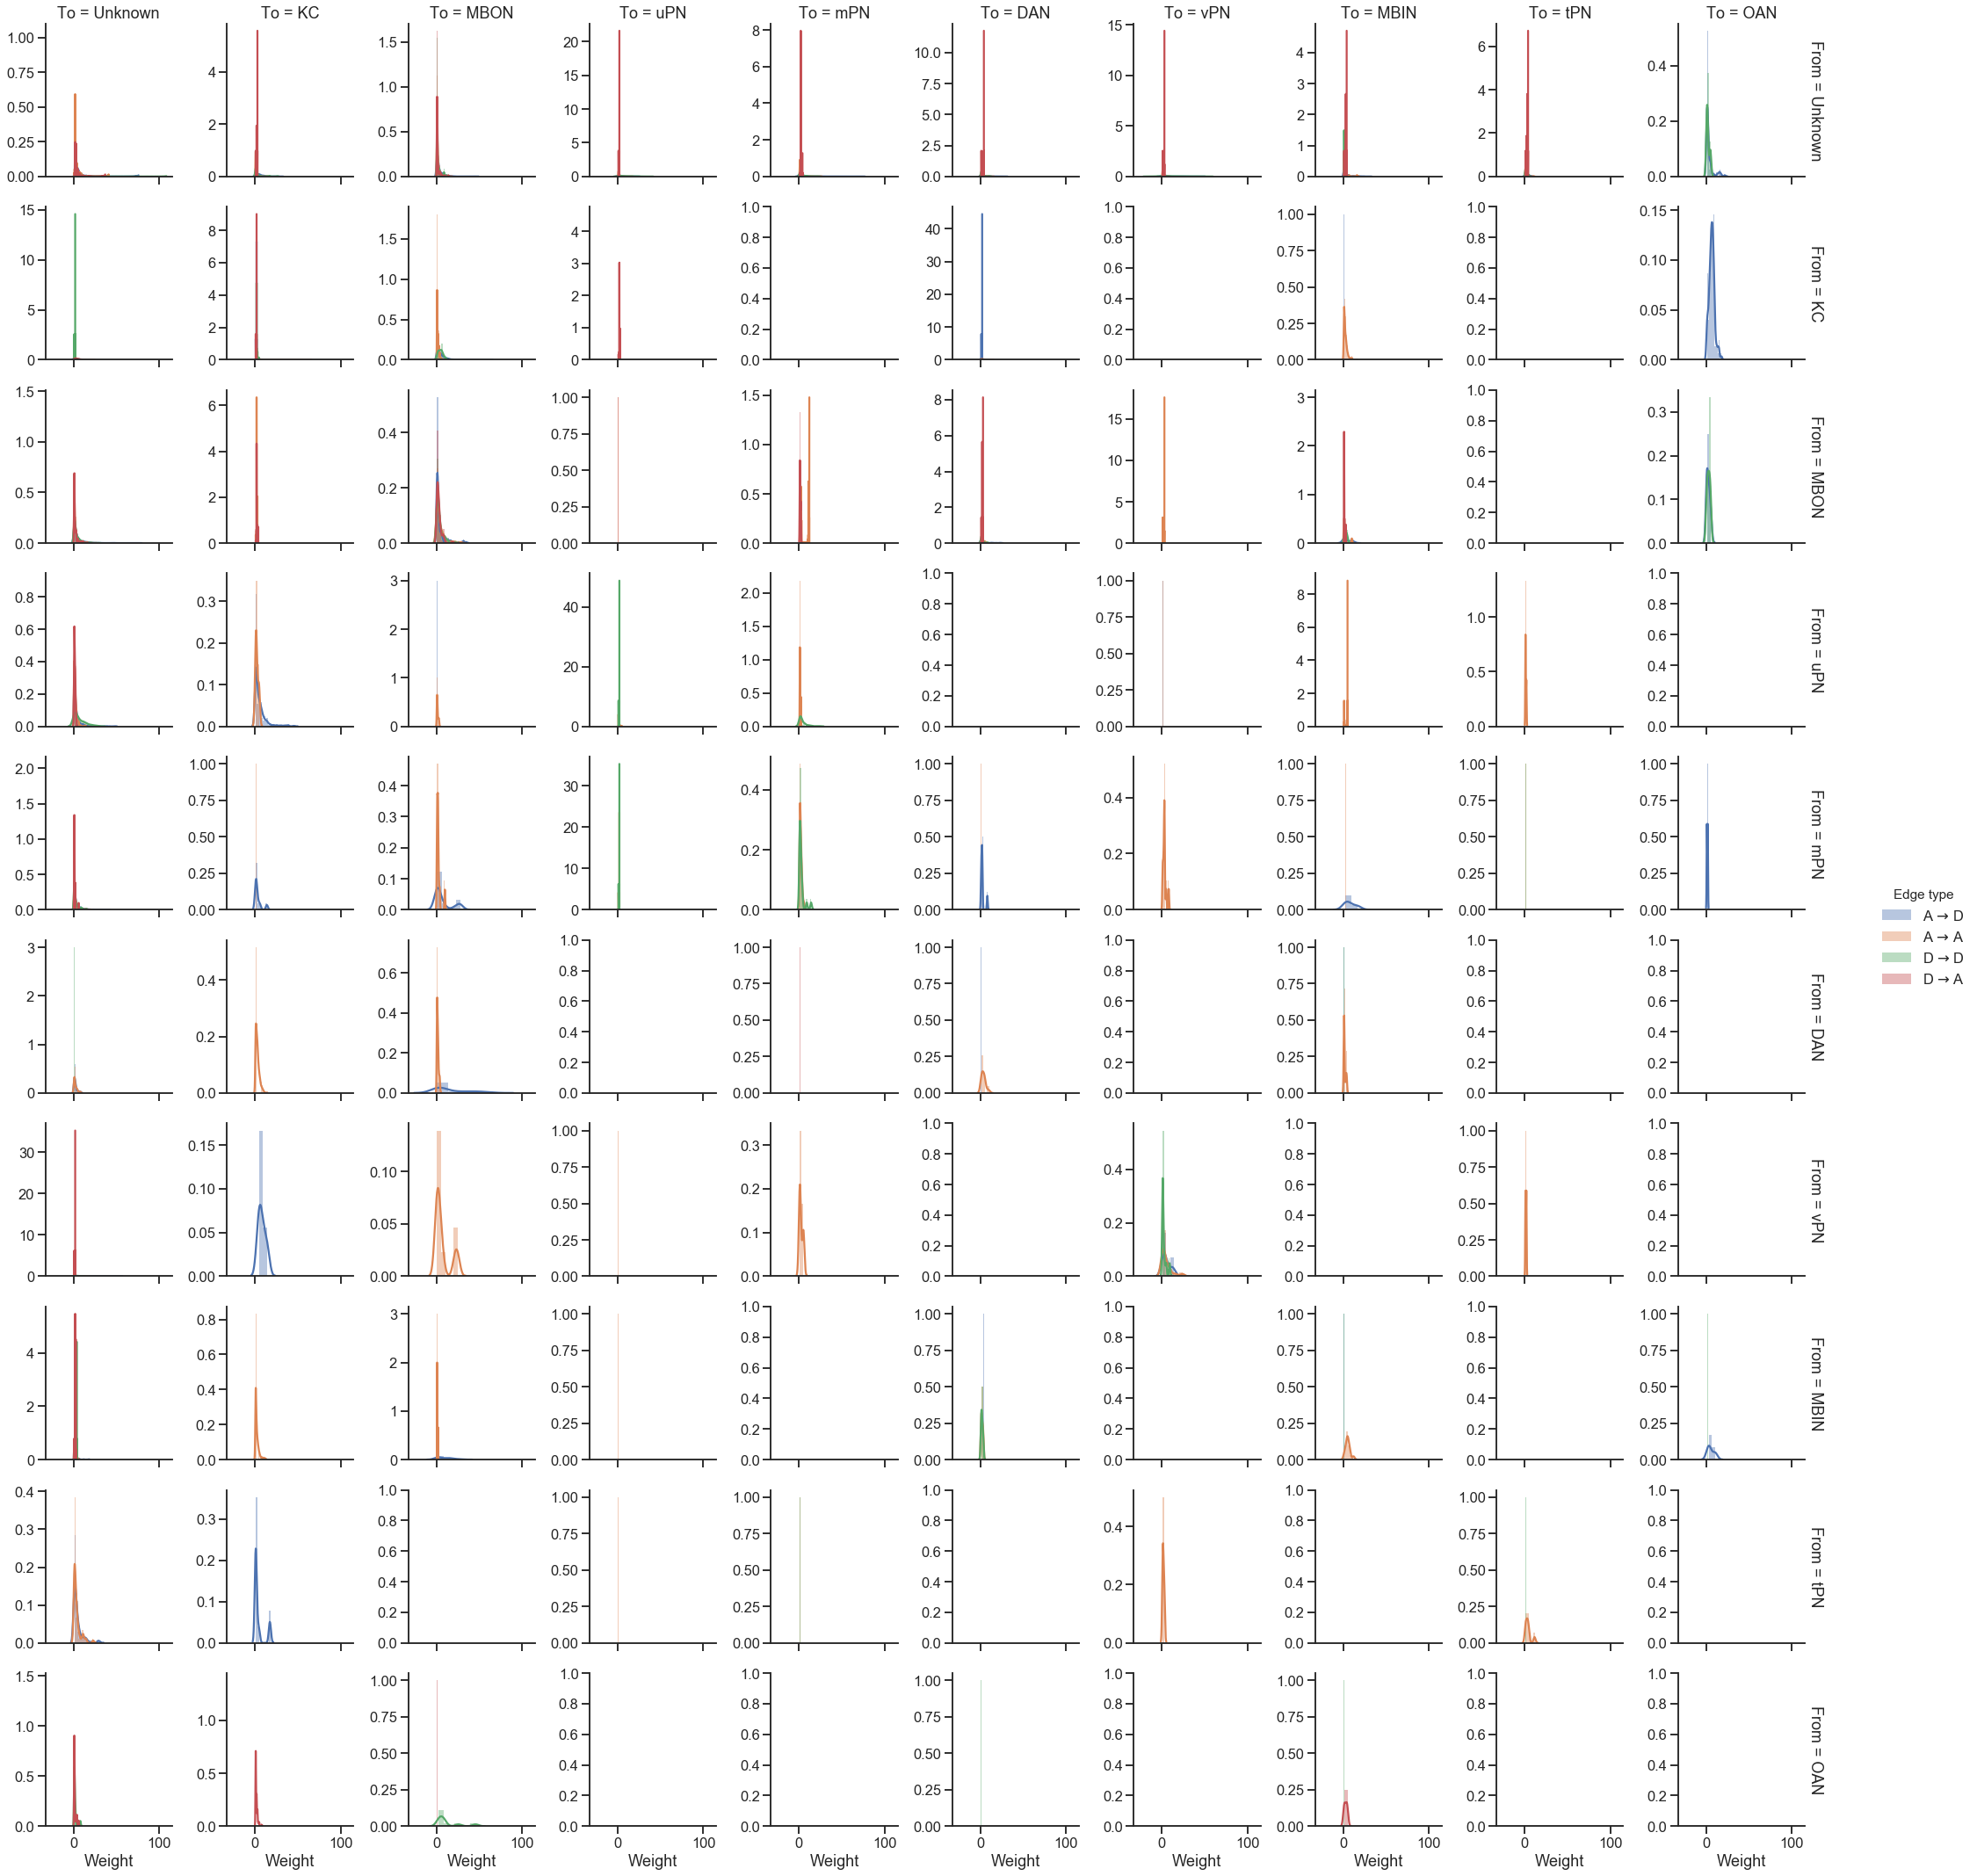

In [9]:
fg = sns.FacetGrid(
    color_edge_df,
    row="From",
    col="To",
    hue="Edge type",
    sharex=True,
    sharey=False,
    margin_titles=True,
)
fg = fg.map(sns.distplot, "Weight")
fg = fg.add_legend()


 # Nonzero log edge weight split by synapse type

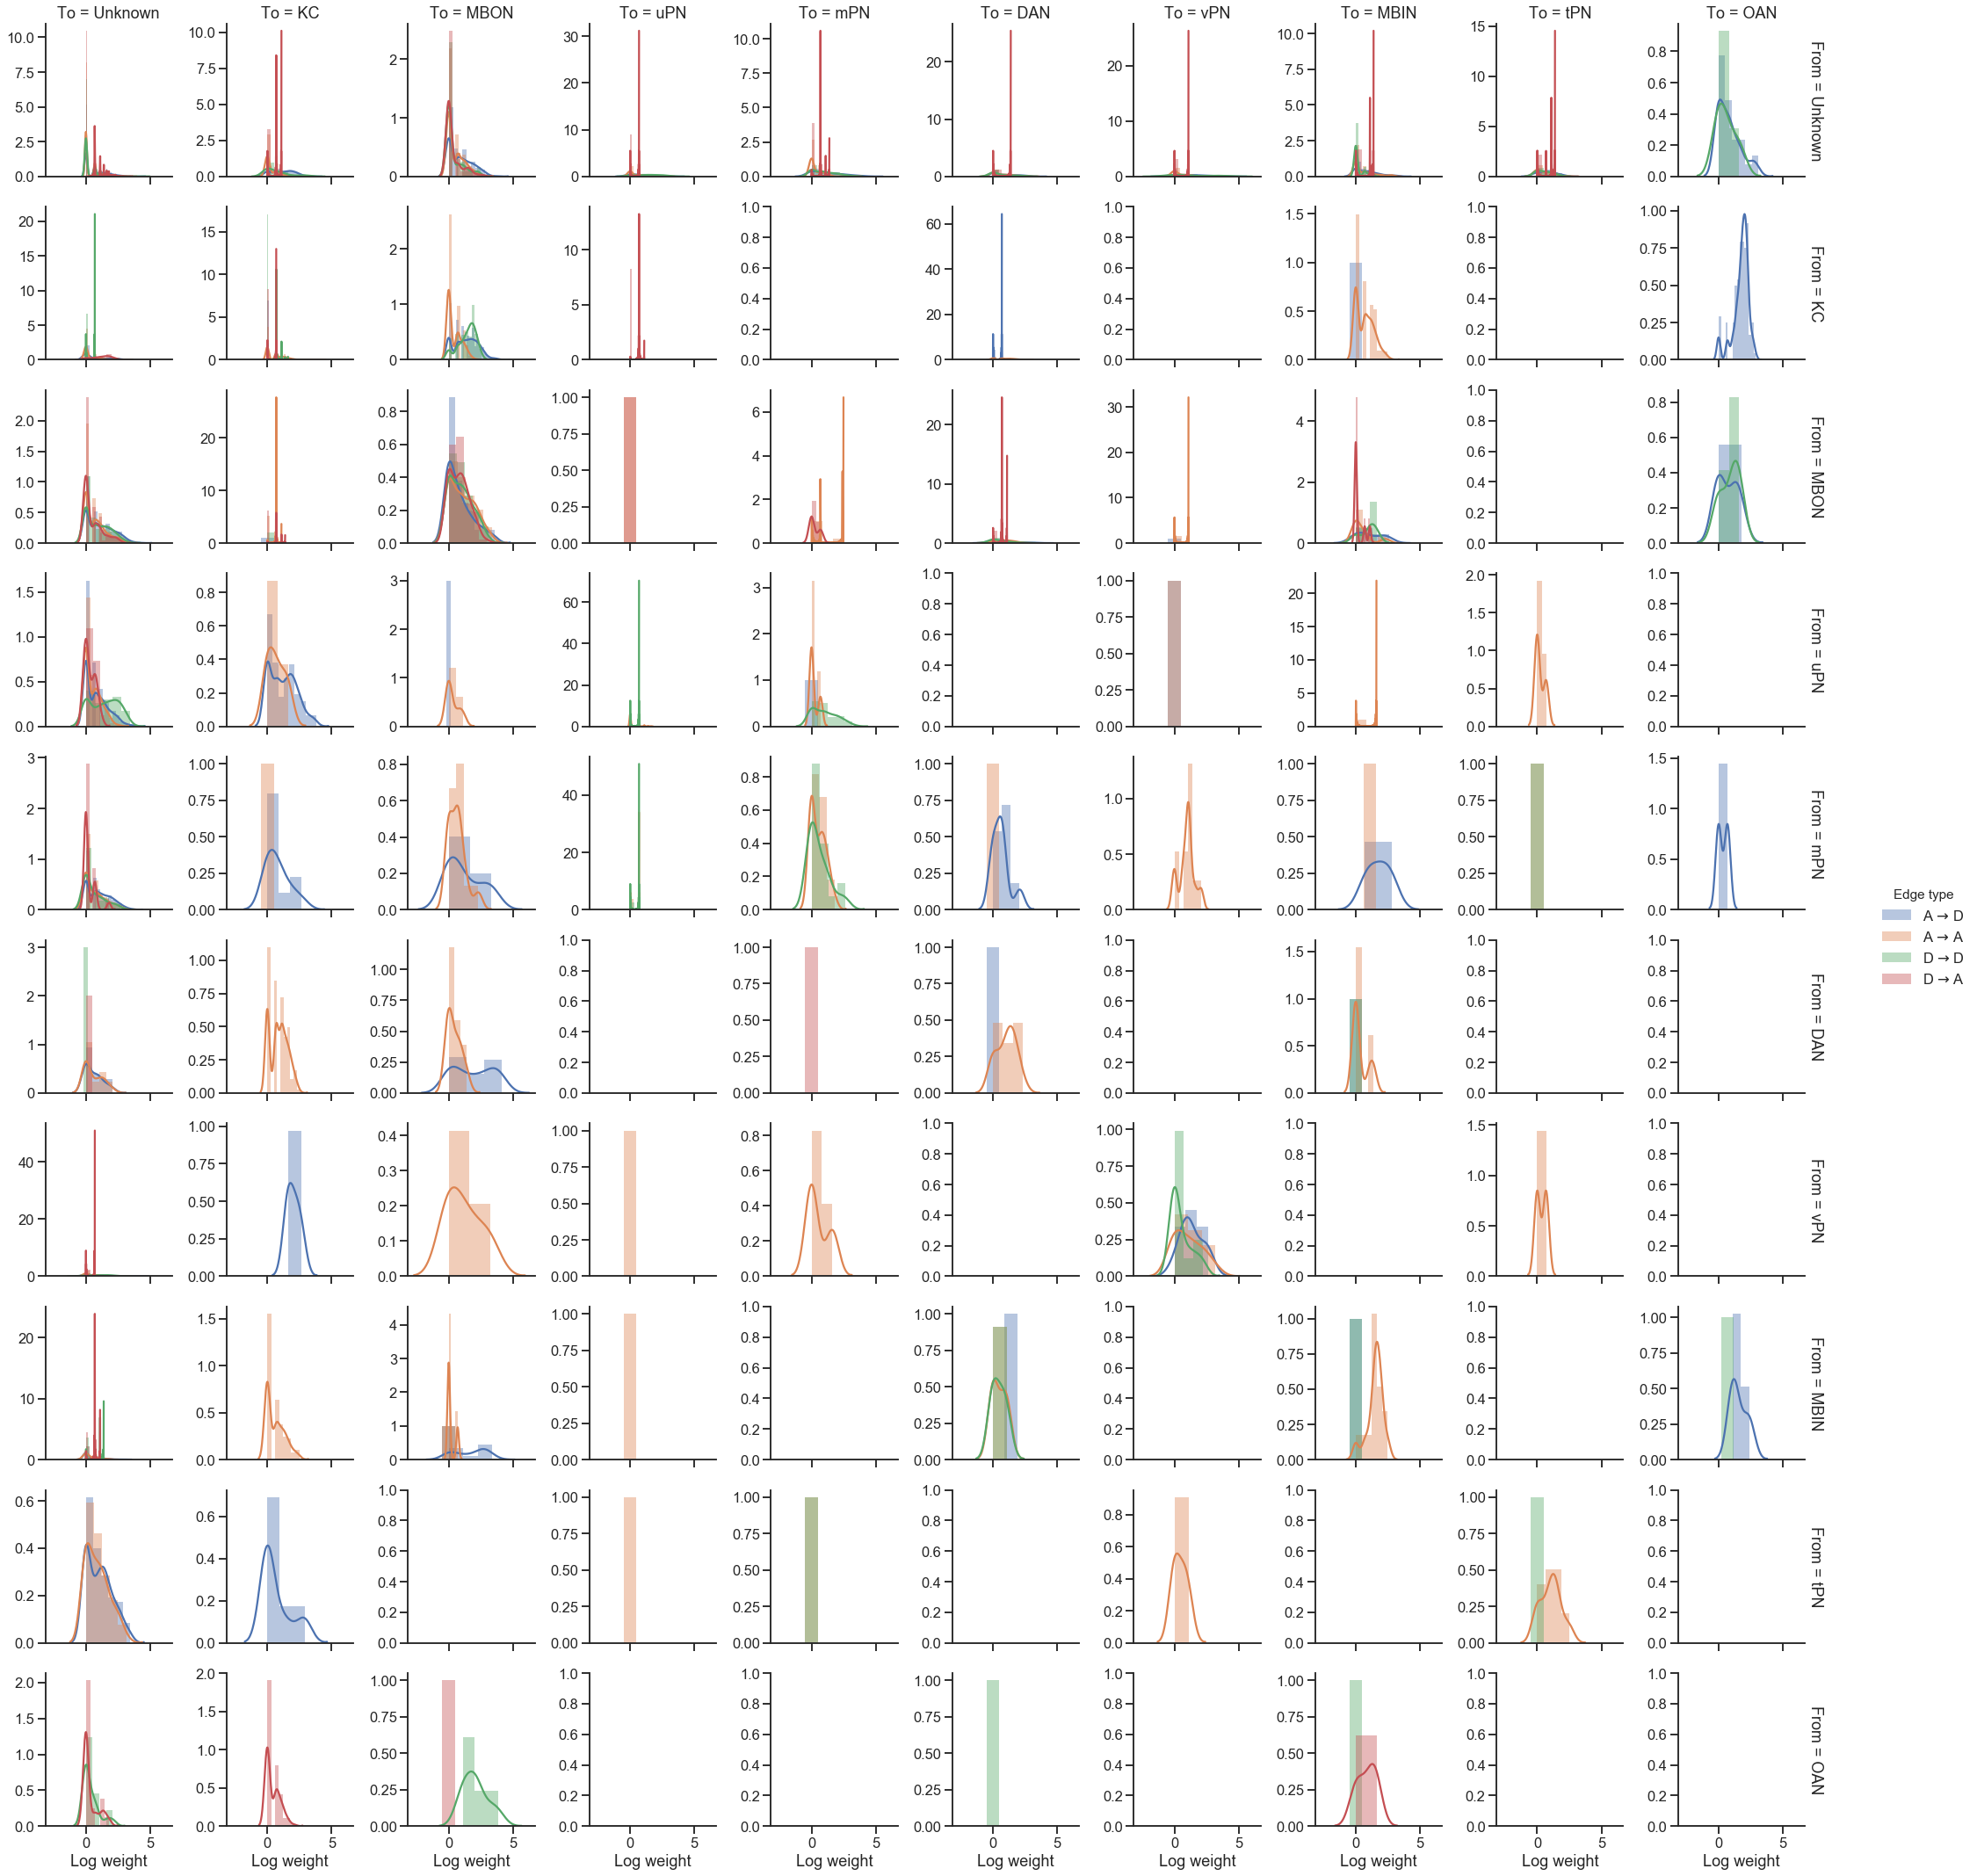

In [10]:
fg = sns.FacetGrid(
    color_edge_df,
    row="From",
    col="To",
    hue="Edge type",
    sharex=True,
    sharey=False,
    margin_titles=True,
)
fg = fg.map(sns.distplot, "Log weight")
fg = fg.add_legend()


 ## TODO
 - Block-wise degree distributions, conditioning on different known cell types
    - Side
    - class types
    - side and class types